# Single Mean - Hypothesis Testing with T Test

---

## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.power import TTestIndPower

plt.style.use("fivethirtyeight")
%matplotlib inline

In [2]:
def sample_creator(n, mean, std):
    sample = stats.norm.rvs(loc=0, scale=std, size=n)
    sample = sample - np.mean(sample)
    sample = sample * (std/sample.std(ddof=1))
    return sample + mean

---

Utilizzato per fare inferenza sulla media del *sample*, in contesti in cui non è corretto utilizzare lo *Z* Test.

Si usa nei contesti in cui il *sample size* non è particolarmente esteso, e quindi il calcolo dello *standard error* non è così affidabile.

La maggiore *probability mass* sulle code della *t-distribution* implica che sia molto più probabile che delle osservazioni cadano a più di due deviazioni standard dalla media. Ed è proprio questo spessore extra sulle code che aiuta a mitigare gli effetti di una stima meno affidabile dello *standard error*.

La *test statistic* da utilizzare è il *t-score*:

$$\large T=\frac{\bar{x}-\mu_{null}}
{\left( \frac{s}{\sqrt{n}} \right)}$$

Il calcolo del *p-value*, quindi, sarà basato sull'utilizzo della *t-distribution*. Il numero di *degrees of freedom* da associare a quest'ultima dev'essere pari al *sample size* meno uno.

$$\large df = n-1$$

---

Se il *sample size* supera le 40 unità, il *t-test* funziona correttamente nella quasi totalità degli scenari.

Con un *sample size* compreso fra 15 e 40, il *t-test* può non restituire risultati corretti se la distribuzione di riferimento è molto asimmetrica o contiene molti outlier.

Con un *sample size* inferiore a 15, bisognerebbe evitare di usare la procedura.

---

Il **power** di un test può essere calcolato attraverso il **Cohen's *d* index**, che descrive l'*effect size* d'interesse in *standard deviation units*.

$$\large d=\frac{|\mu_{target}-\mu|}{s}$$

Notiamo l'utilizzo di $s$ e non $\sigma$ in quanto la deviazione standard della popolazione non è nota.

Si è stabilità che un *effect size* è **small** se è compreso fra 0.2 e 0.5 deviazioni standard; è **medium** se è compreso fra 0.5 e 0.8 deviazioni standard; è **large** se supera le 0.8 unità di deviazione standard.

Per mettere in relazione il *Cohen's index* con il *sample size*, è stato definito il **noncentrality parameter** $\delta$.

$$\large \delta=d\sqrt{n}$$

E' sulla base di quest'ultimo che si può calcolare il *power* del test dal punto di vista analitico, ma all'atto pratico si usa il codice per risolvere direttamente per il *sample size* necessario a ottenere il *power* desiderato.

---

**Esempio** per il calcolo del *sample size* in funzione dell'*effect size* d'interesse e con 80% di *power test*.

In [3]:
effect_size = 0.8
alpha = 0.05
power = 0.8

power_analysis = TTestIndPower()

sample_size = power_analysis.solve_power(effect_size = effect_size, 
                                         power = power, 
                                         alpha = alpha)
sample_size

25.524572500479355

**Plotting** dell'andamento del *test power* in funzione dell'*effect size* e del *sample size*.

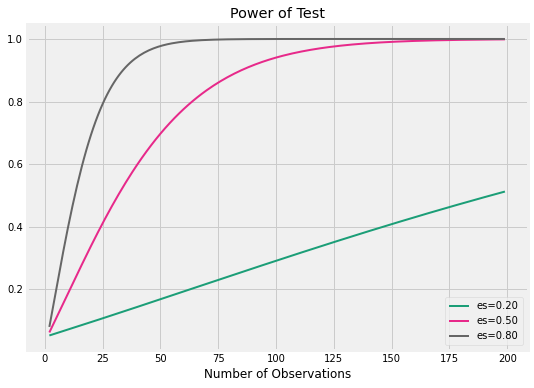

In [4]:
fig, ax = plt.subplots(figsize = (8, 6))

fig = TTestIndPower().plot_power(dep_var = "nobs",
                                 nobs = np.arange(2, 200),
                                 effect_size = np.array([0.2, 0.5, 0.8]),
                                 alpha = 0.05,
                                 ax = ax) 

---

**\[Esempio\]** Un sample di 22 soggetti ha pranzato mentre giocava al pc. Sono stati calcolati i grammi di biscotti consumati come snack in seguito al pranzo. La sample mean è 52.1g, con deviazione standard 45.1g. Supponendo che la quantità corretta da assumere fosse 30g, verificare se i dati confermano il fatto che chi pranza distrattamente presenta una media di biscotti mangiati diversa dal valore corretto.

In [5]:
n = 22
mean = 52.1
std = 45.1

sample = sample_creator(n, mean, std)
sample.mean(), sample.std()

(52.1, 44.0630797834196)

In [6]:
h0 = 30

test_statistic, p_value = stats.ttest_1samp(
    a = sample,
    popmean = h0,
    nan_policy = "omit")

test_statistic, p_value

(2.2984077226629216, 0.03190848757439678)

---

**[Esempio]** Si è stimato che gli atleti hanno un tempo di reazione medio di 0.95s per un certo test. Ci sono 25 atleti che si sottopongono al test ma del tutto disidratati. Il tempo di reazione medio di questi 25 è di 1s, con deviazione standard di 0.18s. Questi dati sono sufficienti ad affermare che il tempo di reazione medio per gli atleti disidratati è maggiore di 0.95?

In [7]:
n = 25
mean = 1
std = 0.18

sample = sample_creator(n, mean, std)
sample.mean(), sample.std()

(1.0, 0.1763632614803888)

In [8]:
def t_test_single_mean(sample, h0, alternative = "different"):
    standard_error = np.std(sample, ddof = 1) / np.sqrt(len(sample))
    test_statistic = (np.mean(sample) - h0) / standard_error
    if alternative == "different":
        return 2 * stats.t.sf(x = np.abs(test_statistic), df = len(sample)-1)
    elif alternative == "greater":
        return stats.t.sf(x = test_statistic, df = len(sample)-1)
    else:
        return stats.t.cdf(x = test_statistic, df = len(sample)-1)

In [9]:
t_test_single_mean(sample = sample, h0 = 0.95, alternative = "greater")

0.08881072997206353

Con *significance level* di 0.05 non siamo in grado di rigettare l'ipotesi nulla.

---